# IMMOWEB PROJECT: EXPLORATORY DATA ANALYSIS

## LIBRARIES AND SETTINGS

In [1]:
# Set the notebook to show all outputs in the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#from ydata_profiling import ProfileReport

# This is for reading the locality name properly. In avoiding the encoding error
import csv
import os

import numpy as np

import warnings
warnings.filterwarnings('ignore')

# Pandas options for data wrangling and output set-up 
import pandas as pd
pd.set_option('display.max_columns', None) # display all columns
pd.set_option('display.expand_frame_repr', False) # print all columns and in the same line
pd.set_option('display.max_colwidth', None) # display the full content of each cell
pd.set_option('display.float_format', lambda x: '%.2f' %x) # floats to be displayed with 2 decimal places

# Visualisation libraries and set-up
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
%matplotlib inline

# Set up visualisation preferences
plt.rcParams['font.family'] = "serif"  # Use serif fonts for plots
sns.set_style('whitegrid')  # Set seaborn grid style
# sns.set_style('darkgrid')

## FUNCTIONS USED RECURRENTLY

In [2]:
# Function to run basic data frame description
def Descriptives(df):
    print("Looking at the shape to see the number of records:", df.shape)
    print("\nDescription of the file to check values range:")
    print(df.describe().transpose())
    print("\nAttributes and respective data types:")
    print(df.info())

def MemOptimisation(df):
    print(f"\nAmount of memory used by all attributes: {df.memory_usage(deep=True).sum()}\n")
    
    # Optimise memory usage
    for i in categoric_cols:
        df[i] = df[i].astype('category')
    for i in numeric_cols:
        df[i] = pd.to_numeric(df[i], downcast='integer')
        df[i] = pd.to_numeric(df[i], downcast='float')    

    print(df.info(memory_usage='deep'))
    print("\nAmount of memory used now by all attributes: ",df.memory_usage(deep=True).sum())
    
# Function to check the missing values (NaNs)
def Missing(df):
    try:
        assert df.notnull().all().all()
        print("Good news! There are no missing values.")
    
    except AssertionError:
        print("Count of missing values:")
        print(df.isna().sum())
        print("\nPercentage of missing values:")
        print(df.isna().mean().round(4)*100, "\n")



In [3]:
def Plot_numeric(x):
    
    print(f'\n*** {x.upper()} ***')
    
    fig = plt.figure(figsize=(15, 3))
    
    plt.subplot(121)
    sns.distplot(df[x], color = 'salmon')
    plt.xlabel('')
    plt.title(f'{x} Distribution')
    
    plt.subplot(122)
    sns.boxplot(x=df[x], color = 'salmon', width=0.4, linewidth=2) 
    plt.xlabel('')
    plt.title(f'{x} Boxplot')
    
    plt.show()

In [4]:
def Plot_category(x):
    print(f'\n*** {x.upper()} ***')

    # Sort the categories by count
    order = df[x].value_counts().index

    fig, ax = plt.subplots(figsize=(10, 3))

    sns.countplot(data=df, y=df[x], order=order, color='salmon', width=0.4, ax=ax)

    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(f'{x.upper()} COUNT')

    # Add count labels to bars
    for p in ax.patches:
        count = int(p.get_width())
        ax.text(p.get_width() + 0.5, p.get_y() + p.get_height() / 2,
                f'{count:,}', va='center')

    plt.show()

## START OF ANALYSIS: LOAD DATA & CLEAN THE VARIABLES

In [19]:
# Load the data (CSV file)
df = pd.read_csv("Cleaned - immoweb-dataset.csv")

In [20]:
# Split the variables into numerical and categorical cols, as different actions to be take for each variable type
numeric_cols = df.select_dtypes(include=np.number).columns
numeric_cols

categoric_cols = df.select_dtypes(exclude=np.number).columns
categoric_cols

Index(['postCode', 'hasAttic', 'hasBasement', 'hasGarden',
       'parkingCountIndoor', 'parkingCountOutdoor', 'hasSwimmingPool',
       'hasTerrace', 'price'],
      dtype='object')

Index(['type', 'subtype', 'bedroomCount', 'bathroomCount', 'region',
       'province', 'habitableSurface', 'buildingCondition', 'hasLift',
       'floodZoneType', 'heatingType', 'kitchenType', 'landSurface',
       'toiletCount', 'epcScore'],
      dtype='object')

# THINGS TO DO
Variables coded 0/1 are not numeric, should be category  
postCode also category  
improve Plot_numeric(i) to show as well the count of values below lower limit and upper limit  
decide what to do with outliers  

There are numeric variables that show as category as we added value "No info", plot excluding category == No info

Look at correlation

Answer the questions using plots


Cleaning numeric columns...
  - bedroomCount: Converting 1952 'No info' values to NaN
  - bathroomCount: Converting 7570 'No info' values to NaN
  - habitableSurface: Converting 8590 'No info' values to NaN
  - toiletCount: Converting 21280 'No info' values to NaN
Dataset shape after cleaning: (76370, 24)

DATASET OVERVIEW
Total rows: 76,370
Total columns: 24

Qualitative variables: 16
Quantitative variables: 8

MISSING VALUES ANALYSIS
              Column  Missing Count  Percentage
7        landSurface          36833       48.23
6        kitchenType          34458       45.12
4      floodZoneType          33466       43.82
8        toiletCount          21280       27.86
5        heatingType          20345       26.64
3  buildingCondition          18381       24.07
9           epcScore          11987       15.70
2   habitableSurface           8590       11.25
1      bathroomCount           7570        9.91
0       bedroomCount           1952        2.56


Text(0.5, 1.0, 'Dataset Dimensions')

Text(0, 0.5, 'Count')

Text(0.0, 76470, '76,370')

Text(1.0, 124, '24')

(0.0, 91644.0)

Text(0.5, 1.0, 'Variable Types Distribution')

Text(0, -1.3, 'Total Variables: 24')

Text(0.5, 0, 'Missing Percentage (%)')

Text(0.5, 1.0, 'Percentage of Missing Values per Column')

(0.0, 50.0)

Text(3.055977478067304, 0.0, '2.6%')

Text(10.412269215660599, 1.0, '9.9%')

Text(11.747872201126096, 2.0, '11.2%')

Text(16.195953908602856, 3.0, '15.7%')

Text(24.568351446903236, 4.0, '24.1%')

Text(27.140041901270134, 5.0, '26.6%')

Text(28.364344637946836, 6.0, '27.9%')

Text(44.32087207018463, 7.0, '43.8%')

Text(45.6198114442844, 8.0, '45.1%')

Text(48.729671336912396, 9.0, '48.2%')

(np.float64(-0.05500000000000001),
 np.float64(0.05500000000000001),
 np.float64(-0.05500000000000001),
 np.float64(0.05500000000000001))

(np.float64(-0.05500000000000001),
 np.float64(0.05500000000000001),
 np.float64(-0.05500000000000001),
 np.float64(0.05500000000000001))

Text(0.5, 1.0, 'Dataset Summary')

Text(0.5, 0.98, 'DATASET OVERVIEW')

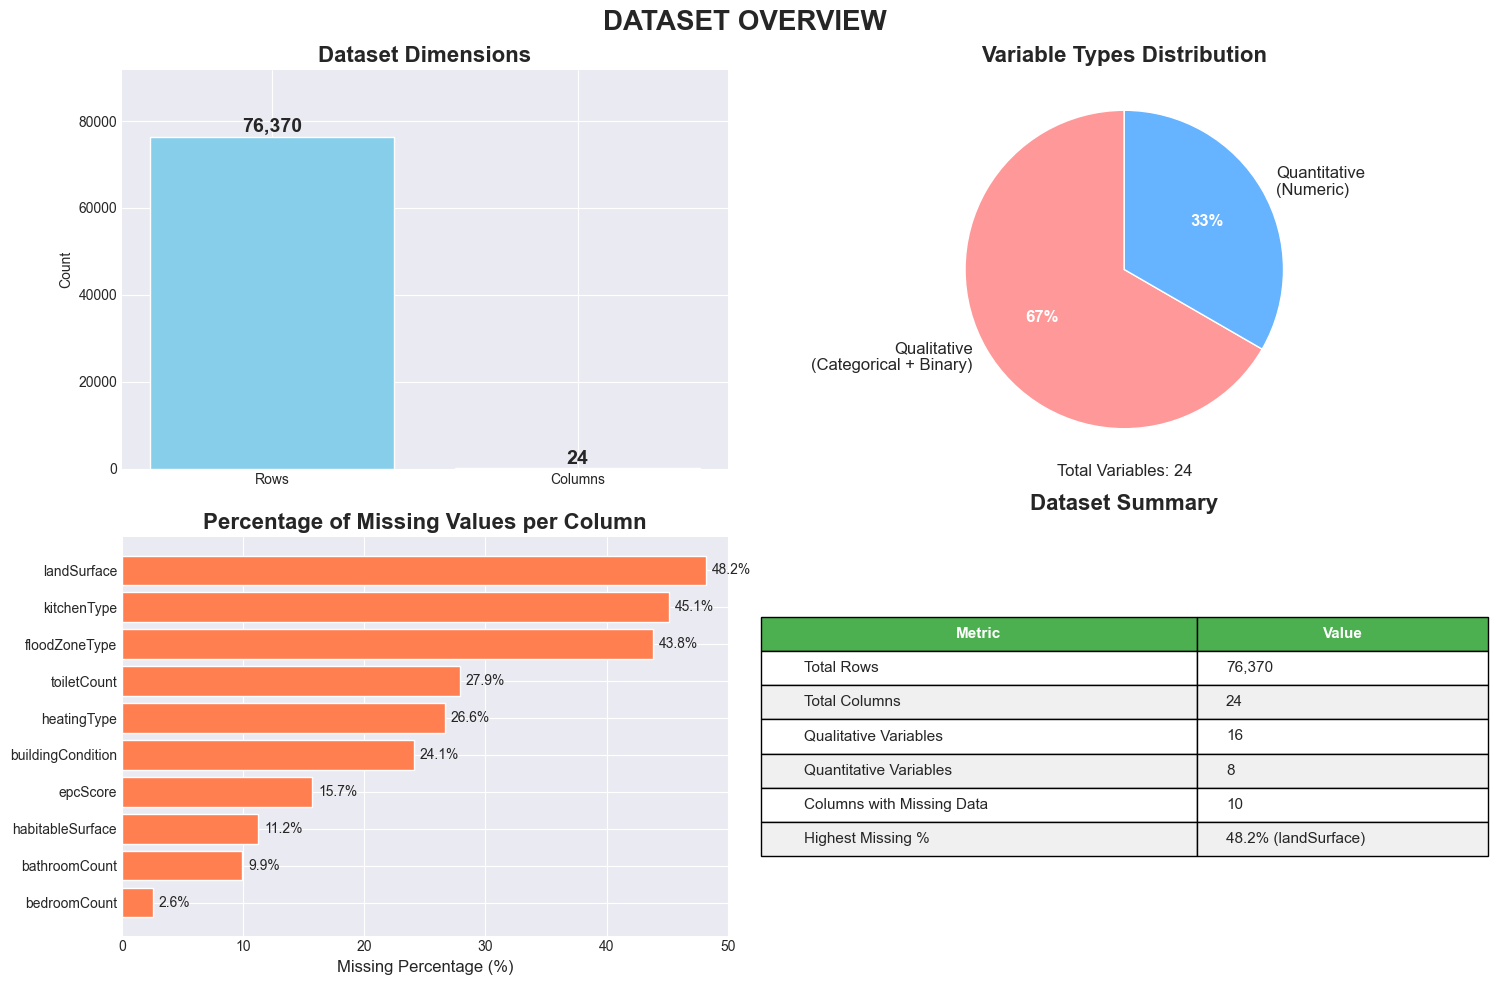

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


# Load the dataset
df = pd.read_csv('Cleaned - immoweb-dataset.csv')

# define variable types
binary_vars = ['hasAttic', 'hasBasement', 'hasGarden', 'hasSwimmingPool', 'hasTerrace']
categorical_vars = ['type','subtype', 'region', 'province', 'postCode','buildingCondition', 
                   'floodZoneType', 'heatingType', 'kitchenType', 'epcScore', 'hasLift']
numeric_vars = ['bedroomCount', 'bathroomCount', 'habitableSurface', 'landSurface',
                'parkingCountIndoor', 'parkingCountOutdoor', 'toiletCount', 'price']

#convert bibary vars to categorical
for var in binary_vars:
    df[var]=df[var].astype('category')

#convert postcode to categorical
df["postCode"] = df["postCode"].astype("category")

#convert haslift to categorical if it's boolean
if df['hasLift'].dtype == 'bool':
    df['hasLift'] = df['hasLift'].astype('categoty')

# Clean numeric columns in place (replace 'No info' with NaN)
print("\nCleaning numeric columns...")
for col in numeric_vars:
    if col in df.columns and df[col].dtype == 'object':
        # Count 'No info' values before cleaning
        no_info_count = (df[col] == 'No info').sum()
        if no_info_count > 0:
            print(f"  - {col}: Converting {no_info_count} 'No info' values to NaN")
        # Replace 'No info' with NaN and convert to numeric
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Verify we still have 24 columns, and length of rows and columns, qualitative and quantitative variables 
print(f"Dataset shape after cleaning: {df.shape}")

print("\n" + "="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"Total rows: {len(df):,}")
print(f"Total columns: {len(df.columns)}")
print(f"\nQualitative variables: {len(categorical_vars) + len(binary_vars)}")
print(f"Quantitative variables: {len(numeric_vars)}")


# Calculate missing values
print("\n" + "="*80)
print("MISSING VALUES ANALYSIS")
print("="*80)
missing_data = []
for col in df.columns:
    # For object columns, check for null and 'No info'
    if df[col].dtype == 'object':
        null_count = df[col].isnull().sum()
        no_info_count = (df[col] == 'No info').sum()
        total_missing = null_count + no_info_count
    else:
        # For numeric columns, only check for null (No info already converted to NaN)
        total_missing = df[col].isnull().sum()
    
    percentage = (total_missing / len(df)) * 100
    if percentage > 0:
        missing_data.append({
            'Column': col,
            'Missing Count': total_missing,
            'Percentage': percentage
        })

missing_df = pd.DataFrame(missing_data).sort_values('Percentage', ascending=False)
print(missing_df.to_string())




#=============================================================visualization========================================================================


# =====Visualization 1: Dataset Overview with 2 subplots=====
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Dataset dimensions visualization
dims_data = ['Rows', 'Columns']
dims_values = [len(df), len(df.columns)]
bars1 = ax1.bar(dims_data, dims_values, color=['skyblue', 'lightcoral'])
ax1.set_title('Dataset Dimensions', fontsize=16, fontweight='bold')
ax1.set_ylabel('Count')
for i, (bar, val) in enumerate(zip(bars1, dims_values)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
             f'{val:,}', ha='center', va='bottom', fontsize=14, fontweight='bold')
ax1.set_ylim(0, max(dims_values) * 1.2)

# 2. Variable types visualization
var_types = ['Qualitative\n(Categorical + Binary)', 'Quantitative\n(Numeric)']
var_counts = [len(categorical_vars) + len(binary_vars), len(numeric_vars)]
colors = ['#ff9999', '#66b3ff']
wedges, texts, autotexts = ax2.pie(var_counts, labels=var_types, colors=colors, 
                                    autopct='%1.0f%%', startangle=90, 
                                    textprops={'fontsize': 12})
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax2.set_title('Variable Types Distribution', fontsize=16, fontweight='bold')
# Add counts to labels
ax2.text(0, -1.3, f'Total Variables: {sum(var_counts)}', ha='center', fontsize=12)

# 3. Missing values percentage bar chart
missing_sorted = missing_df[missing_df['Percentage'] > 0].sort_values('Percentage', ascending=True)
bars3 = ax3.barh(missing_sorted['Column'], missing_sorted['Percentage'], color='coral')
ax3.set_xlabel('Missing Percentage (%)', fontsize=12)
ax3.set_title('Percentage of Missing Values per Column', fontsize=16, fontweight='bold')
ax3.set_xlim(0, 50)
for i, (bar, pct) in enumerate(zip(bars3, missing_sorted['Percentage'])):
    ax3.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{pct:.1f}%', ha='left', va='center', fontsize=10)

# 4. Summary statistics table
summary_data = [
    ['Total Rows', f'{len(df):,}'],
    ['Total Columns', f'{len(df.columns)}'],
    ['Qualitative Variables', f'{len(categorical_vars) + len(binary_vars)}'],
    ['Quantitative Variables', f'{len(numeric_vars)}'],
    ['Columns with Missing Data', f'{len(missing_sorted)}'],
    ['Highest Missing %', f'{missing_sorted["Percentage"].max():.1f}% ({missing_sorted.iloc[-1]["Column"]})']
]

ax4.axis('tight')
ax4.axis('off')
table = ax4.table(cellText=summary_data, 
                  colLabels=['Metric', 'Value'],
                  cellLoc='left',
                  loc='center',
                  colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)
ax4.set_title('Dataset Summary', fontsize=16, fontweight='bold', pad=20)

# Style the table
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_facecolor('#4CAF50')
        cell.set_text_props(weight='bold', color='white')
    else:
        cell.set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')

plt.suptitle('DATASET OVERVIEW', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()




# ==================================== Function to plot numeric variables with outlier information ========================================

def plot_numeric_with_outliers(df, col, ax):
    """Plot numeric variable with outlier information"""
    data = df[f'{col}_clean'].dropna()
    
    # Calculate outliers using IQR method
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_below = (data < lower_bound).sum()
    outliers_above = (data > upper_bound).sum()
    
    # Create boxplot
    ax.boxplot(data, vert=False, patch_artist=True,
               boxprops=dict(facecolor='lightblue', alpha=0.7),
               medianprops=dict(color='red', linewidth=2))
    
    # Add outlier counts
    ax.text(0.02, 0.95, f'Below lower limit: {outliers_below}', 
            transform=ax.transAxes, va='top', fontsize=10)
    ax.text(0.02, 0.85, f'Above upper limit: {outliers_above}', 
            transform=ax.transAxes, va='top', fontsize=10)
    
    ax.set_xlabel(col)
    ax.set_title(f'{col} Distribution with Outliers', fontsize=12)
    



*** POSTCODE ***


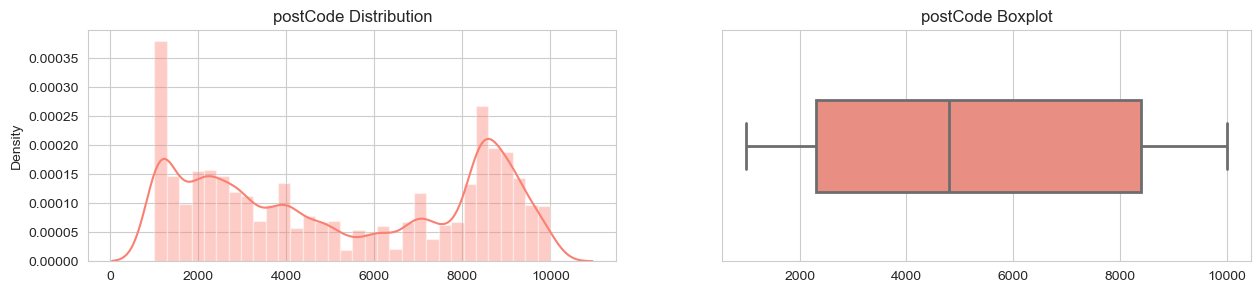


*** HASATTIC ***


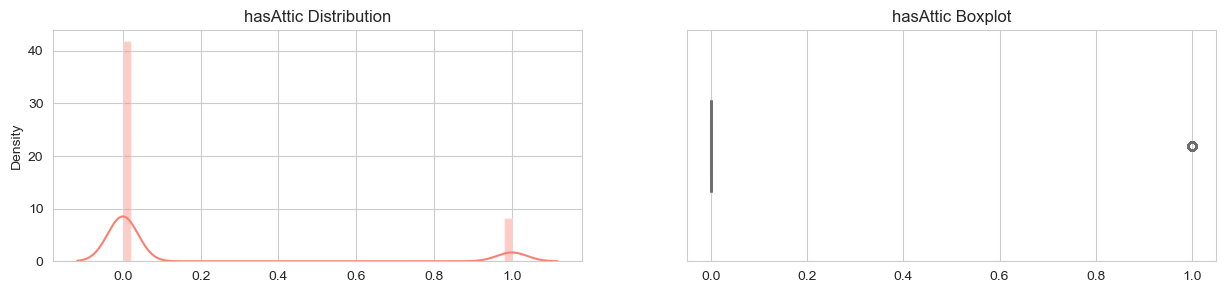


*** HASBASEMENT ***


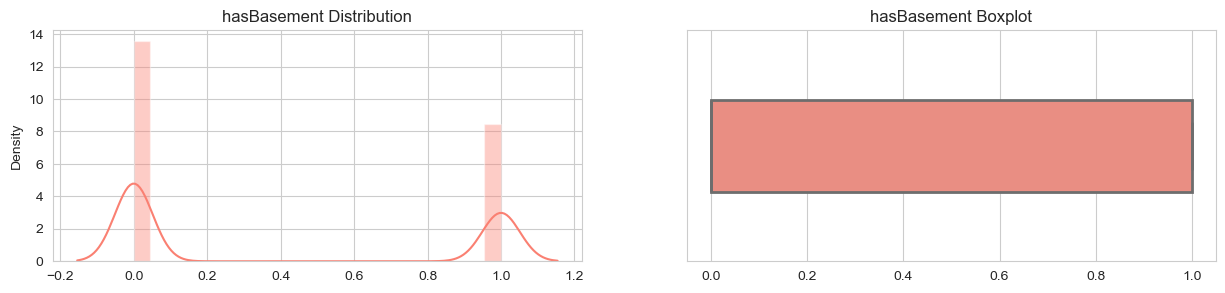


*** HASGARDEN ***


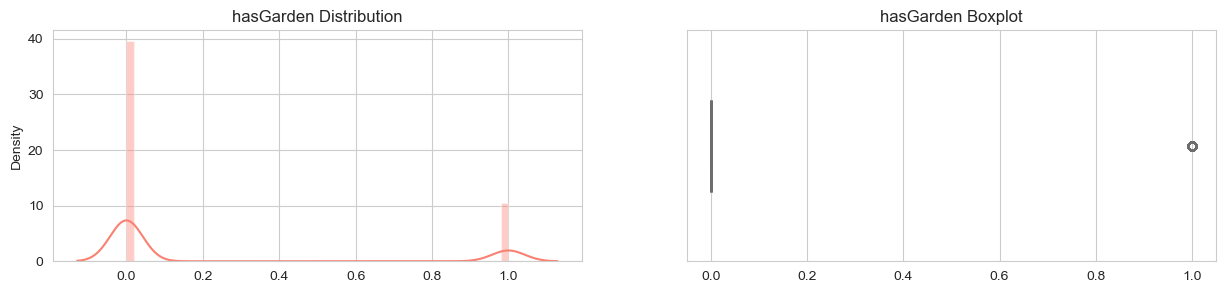


*** GARDENSURFACE ***


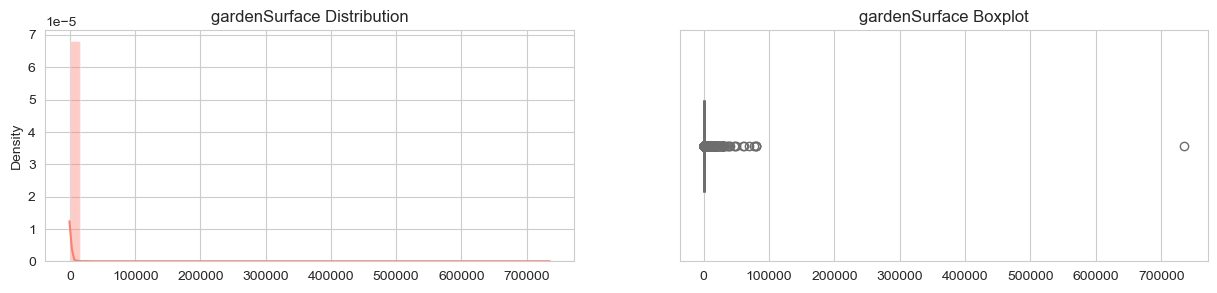


*** PARKINGCOUNTINDOOR ***


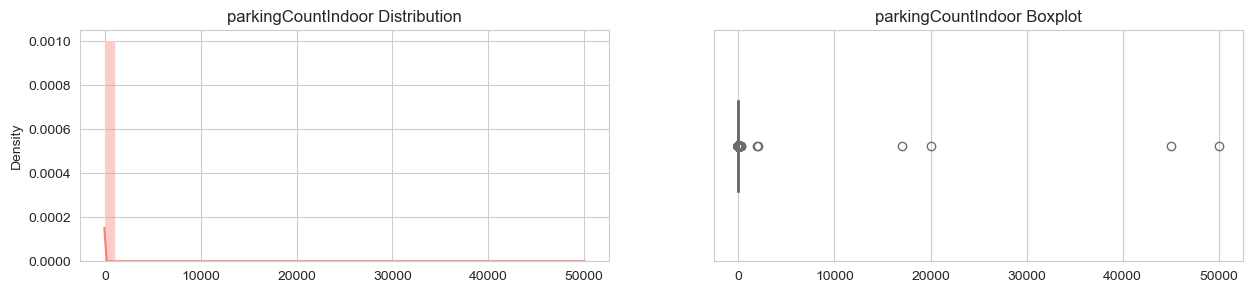


*** PARKINGCOUNTOUTDOOR ***


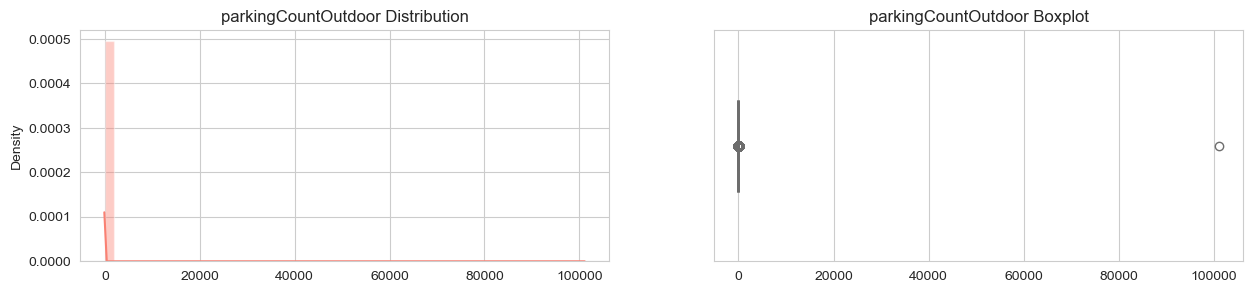


*** HASSWIMMINGPOOL ***


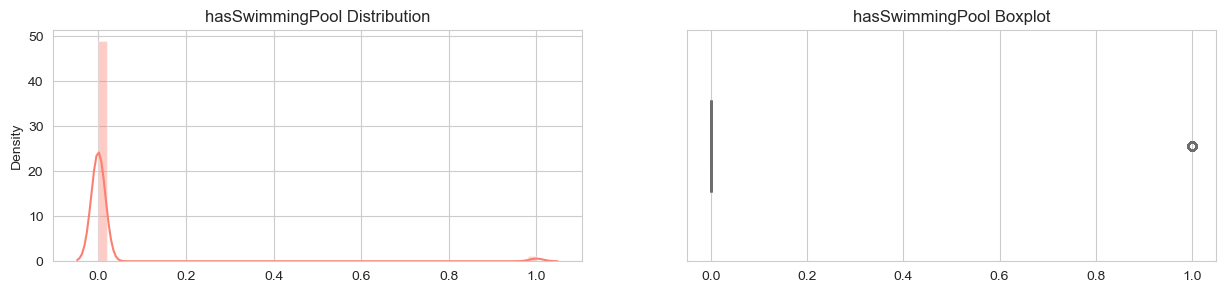


*** HASTERRACE ***


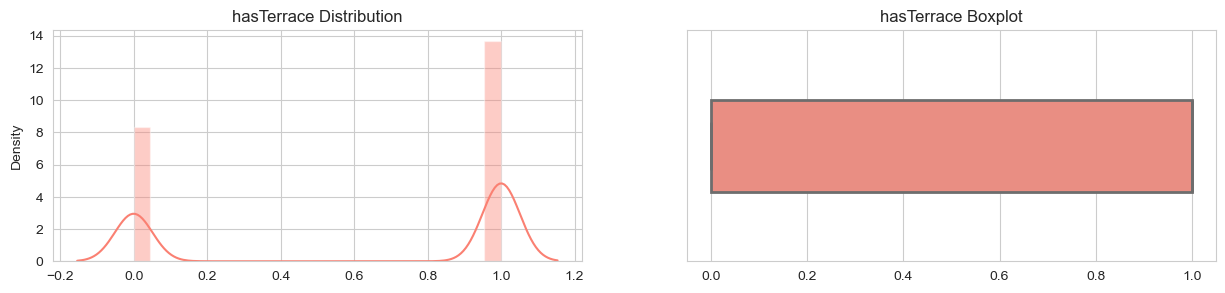


*** PRICE ***


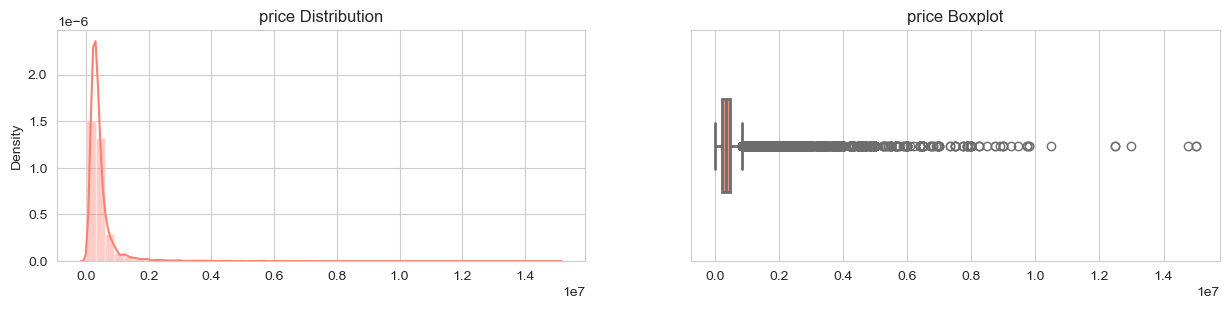

In [17]:
for i in numeric_cols:
    Plot_numeric(i)


*** TYPE ***


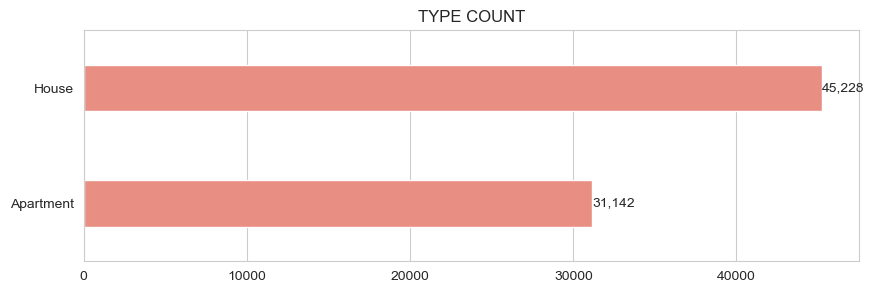


*** SUBTYPE ***


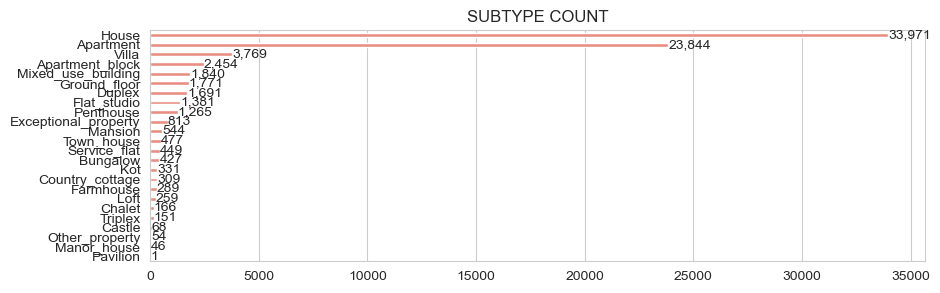


*** BEDROOMCOUNT ***


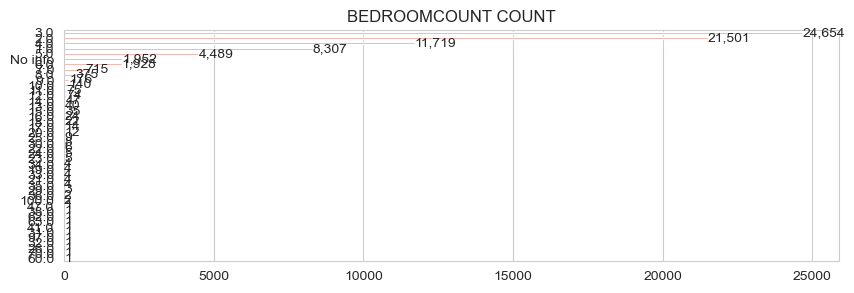


*** BATHROOMCOUNT ***


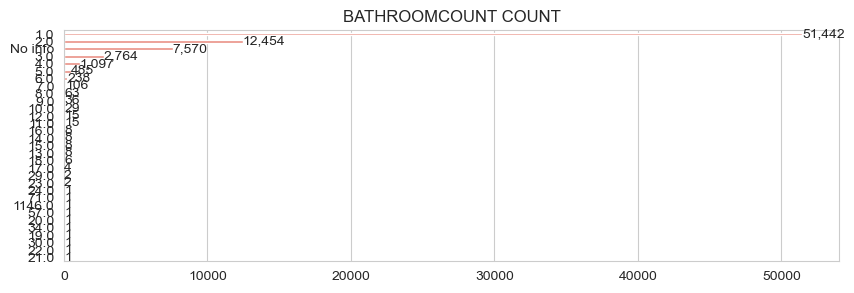


*** REGION ***


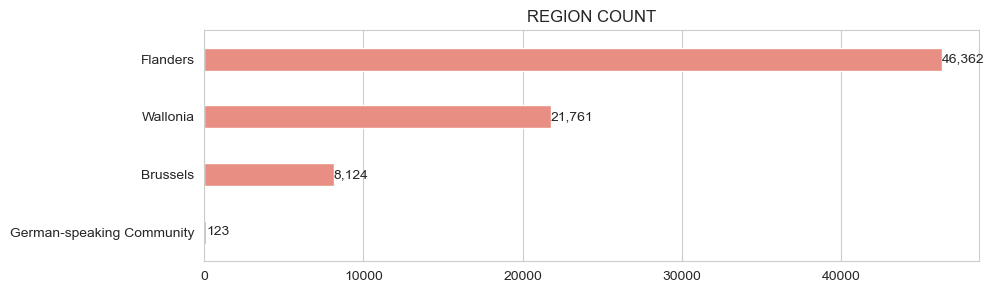


*** PROVINCE ***


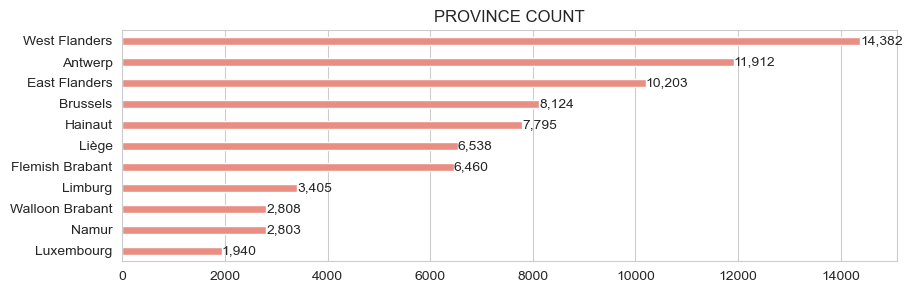


*** LOCALITY ***


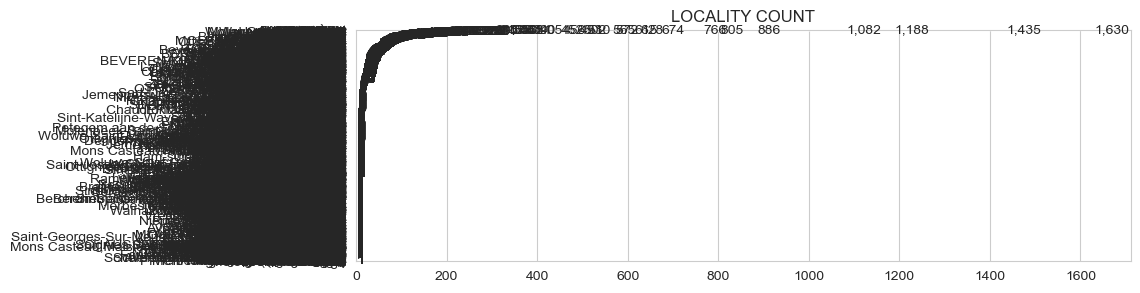


*** HABITABLESURFACE ***


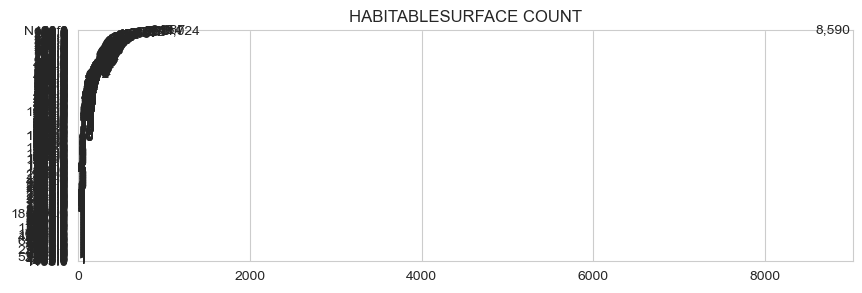


*** BUILDINGCONDITION ***


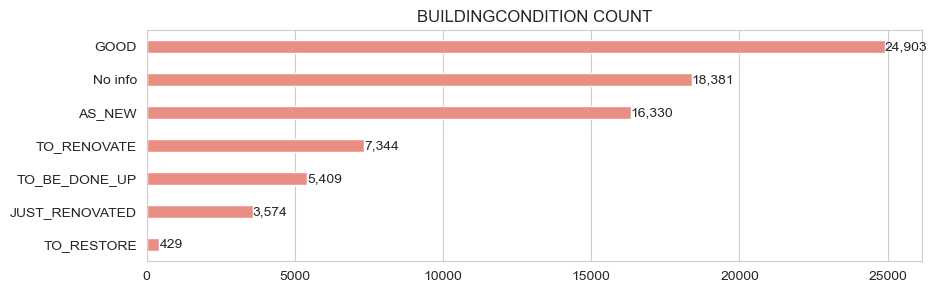


*** BUILDINGCONSTRUCTIONYEAR ***


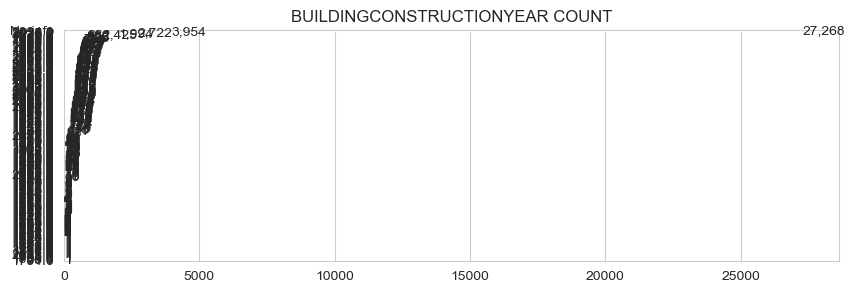


*** HASLIFT ***


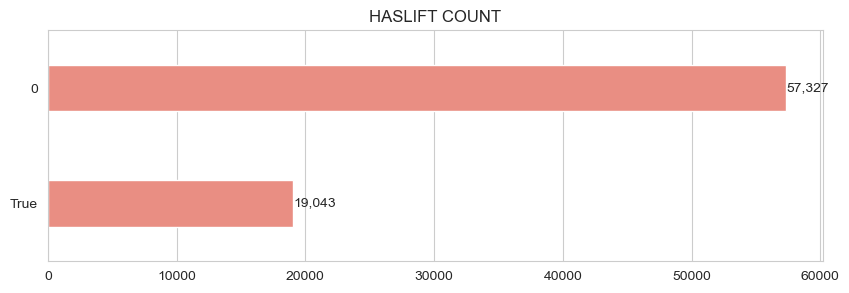


*** FLOODZONETYPE ***


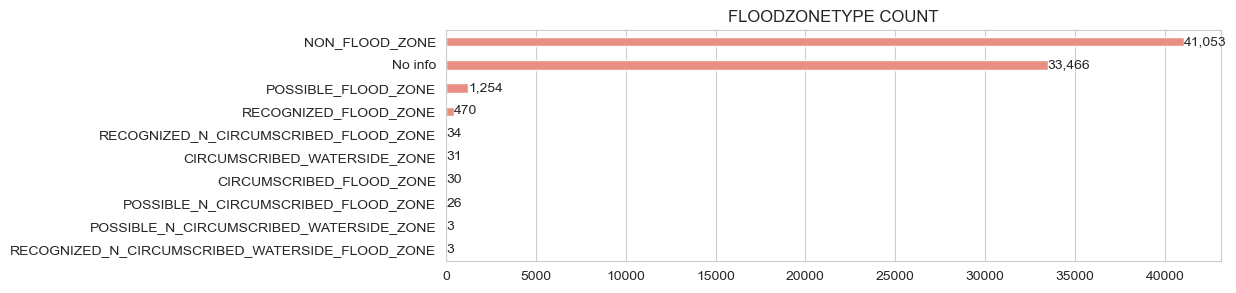


*** HEATINGTYPE ***


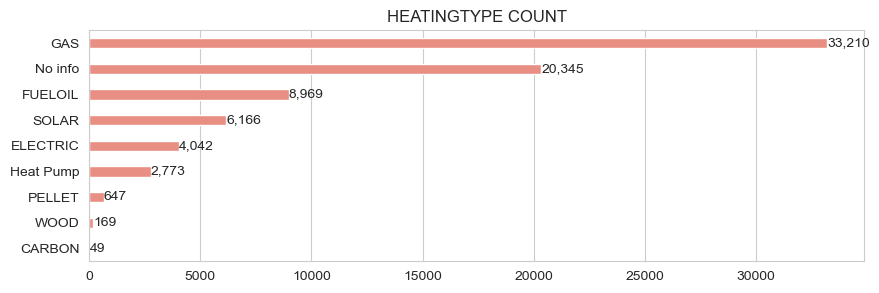


*** KITCHENTYPE ***


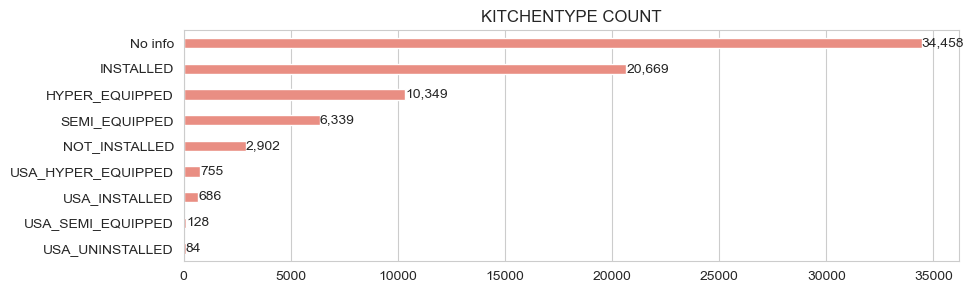


*** LANDSURFACE ***


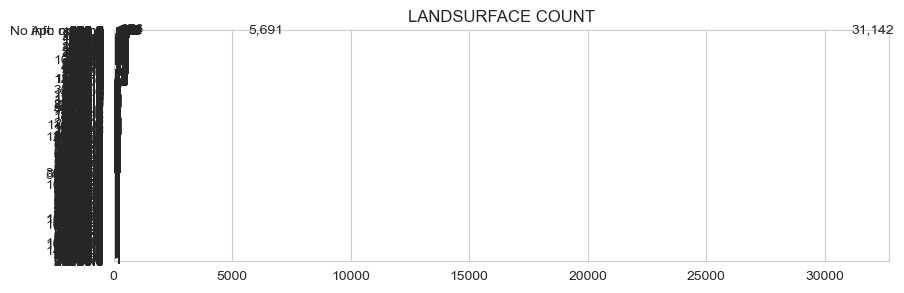


*** GARDENORIENTATION ***


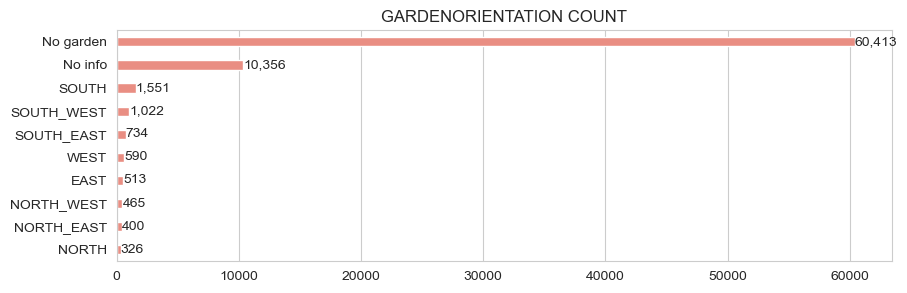


*** TOILETCOUNT ***


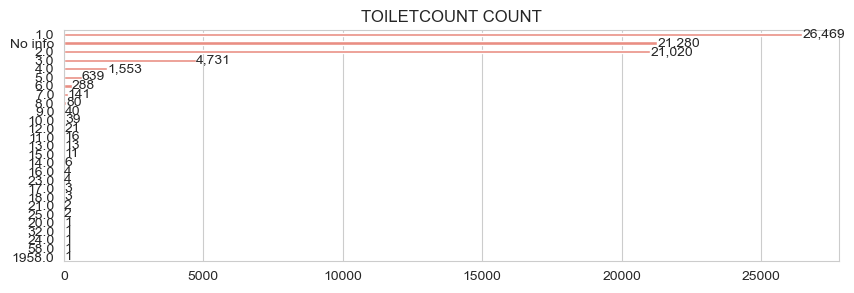


*** TERRACESURFACE ***


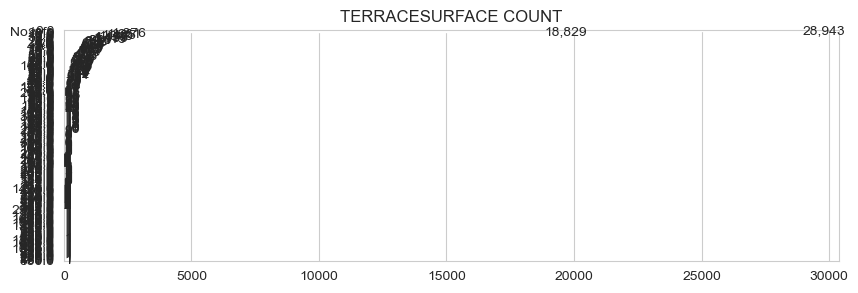


*** TERRACEORIENTATION ***


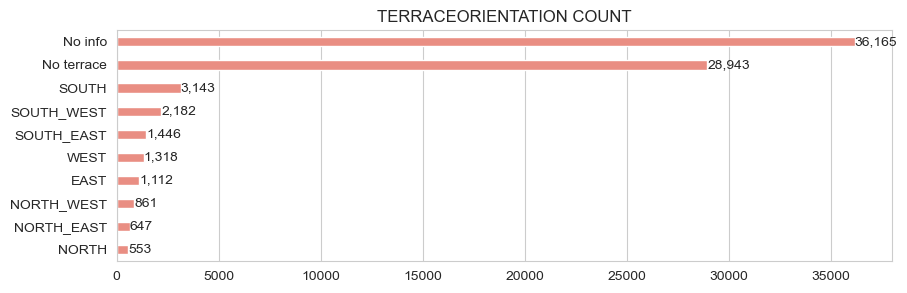


*** EPCSCORE ***


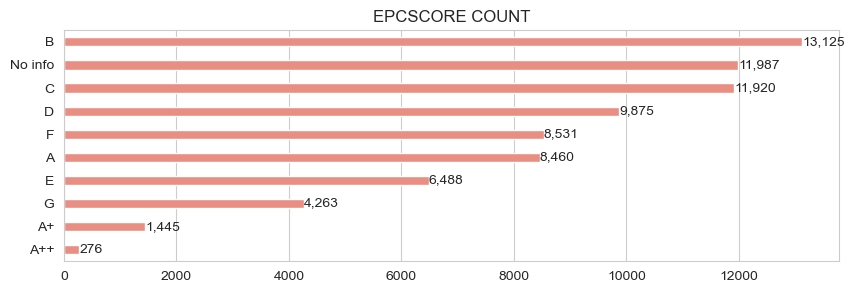

In [21]:
for i in categoric_cols:
    Plot_category(i)

<Axes: >

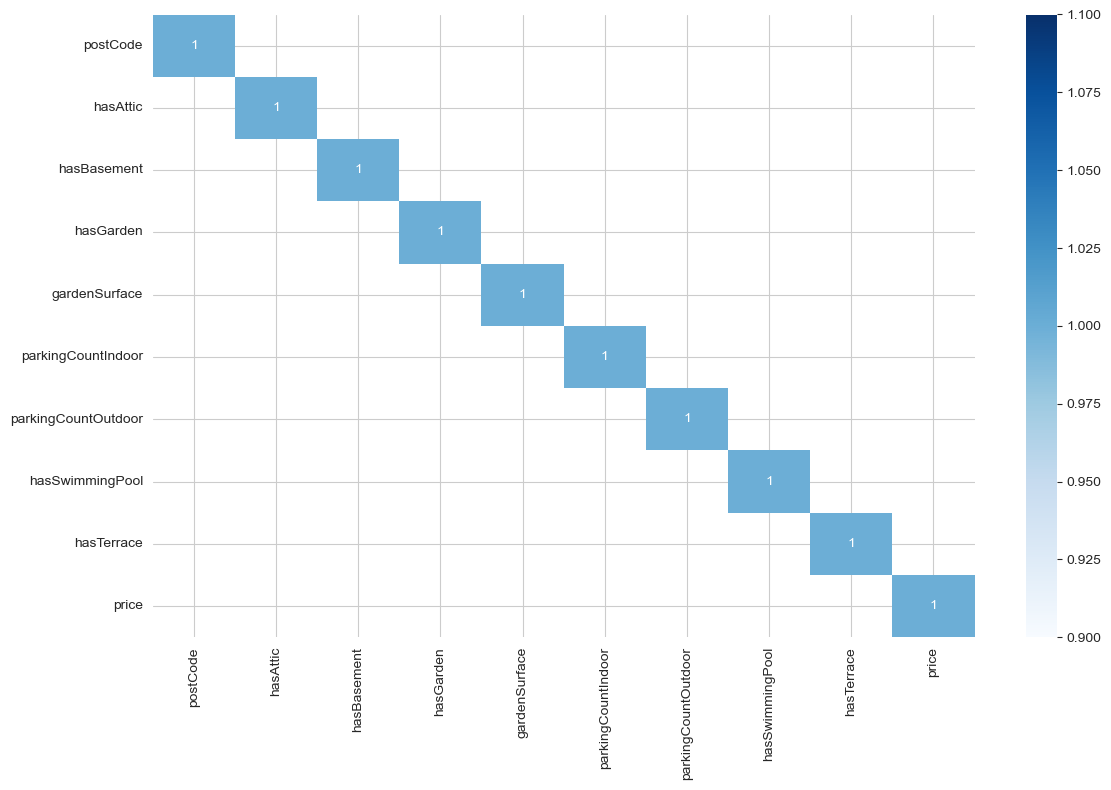

In [22]:
correlations = df.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(12, 8))

# Shows only correlation above +/- 0.3
sns.heatmap(correlations[(correlations > 0.30) | (correlations < -0.30)], cmap='Blues', annot=True, ax=ax)

plt.tight_layout()
plt.show()